## Import packages and set up plot defaults

In [1]:
using CoordinatedPrecoding, OptimalBaseStationClustering, DistributedBaseStationClustering
using PyPlot, LaTeXStrings

PyPlot.rc("lines", linewidth=1., markersize=3, markeredgewidth=0.5)
PyPlot.rc("font", size=8, family="serif", serif="Computer Modern Sans Serif")
PyPlot.rc("text", usetex=true)
PyPlot.rc("text.latex", preamble="\\usepackage{amsmath}")
PyPlot.rc("axes", linewidth=0.5, labelsize=8)
PyPlot.rc("xtick", labelsize=8)
PyPlot.rc("ytick", labelsize=8)
PyPlot.rc("legend", fancybox=true, fontsize=8)
PyPlot.rc("figure", figsize=(3.50,3.50), dpi=125)

## Multicell scenario definition

In [2]:
num_cells = 8; num_MSs_per_cell = 2
num_BS_antennas = 8; num_MS_antennas = 2; num_streams = 1
num_coherence_symbols = 2_700
SNR_dB = 30

# Geography
design_ISD = 500 # equivalent ISD in hexagonal deployment
cell_density = sqrt(3)/2*design_ISD^2 # BSs per m^2, for hexagonal cells
geography_width = sqrt(num_cells*cell_density); MS_serving_distance = 150.

srand(3701233)
simulation_params = Dict(
    "simulation_name" => "convergence",
    "I" => num_cells, "Kc" => num_MSs_per_cell, "M" => num_BS_antennas, "N" => num_MS_antennas, "d" => num_streams,
    "Ndrops" => 1,
    "geography_size" => (geography_width, geography_width),
    "MS_serving_BS_distance" => Nullable(MS_serving_distance),
    "aux_network_params" => Dict(
        "num_coherence_symbols" => num_coherence_symbols,
    ),
)

# Generate network
network =
    setup_random_large_scale_network(num_cells, num_MSs_per_cell, num_MS_antennas, num_BS_antennas,
        num_streams=num_streams, geography_size=(geography_width, geography_width),
        MS_serving_BS_distance=Nullable(MS_serving_distance))
set_average_SNRs_dB!(network, SNR_dB)

## Utility definition

In [3]:
# Throughput
f1 = 1/num_cells; f2 = -1/num_coherence_symbols
α(C) = (f1 + f2*C)*C
t(C, SNR, SINR) = α(C)*log2(1 + SNR) # all MSs are placed a fixed distance to their serving BSs, and the SNRs are thus identical

# Max cluster sizes
D = floor(Int, (num_BS_antennas + num_MS_antennas - num_streams)/(num_MSs_per_cell*num_streams))
_, B = findmax([ t(b, 1., 1.) for b in 1:num_cells])

# System-level objective
f(ts) = sum(ts);

### Create specialized branch and bound method

In [4]:
simulation_params["aux_assignment_params"] =
    Dict("GeneralBranchAndBoundClustering:branching_rule" => :dfs,
         "GeneralBranchAndBoundClustering:improve_initial_incumbent" => false, # gives initial incumbent objective as zero
         "GeneralBranchAndBoundClustering:max_abs_optimality_gap" => 0.,
         "GeneralBranchAndBoundClustering:max_rel_optimality_gap" => 0.,
         "GeneralBranchAndBoundClustering:store_evolution" => true)
BranchAndBoundClustering(channel, network) = GeneralBranchAndBoundClustering(channel, network, f, t, D, B)
GreedyClustering(channel, network) = GeneralGreedyClustering(channel, network, f, t, D, B)
simulation_params["assignment_methods"] = [ BranchAndBoundClustering, GreedyClustering ];

### Simulate

In [5]:
raw_results = simulate_assignment_convergence(network, simulation_params);

-- simulate_assignment_convergence on RandomLargeScaleNetwork(I = 8, Kc = 2, geography_size = (1316.0740129524925,1316.0740129524925), MS_serving_BS_distance = Nullable(150.0)).
--- Ndrops: 1.
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05

### Visualize generated clusters

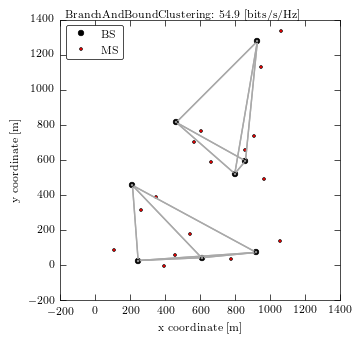

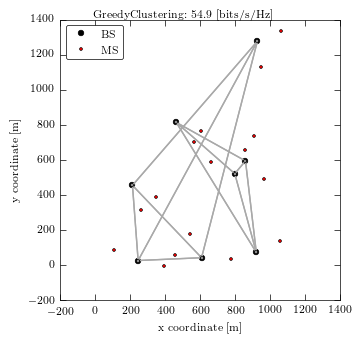

In [6]:
for method in [:BranchAndBoundClustering, :GreedyClustering]
    partition = Partition(raw_results.simulation_results[1].precoding_results[string(method)]["a"])
    title = @sprintf "%s: %.1f [bits/s/Hz]" string(method) f(raw_results.simulation_results[1].precoding_results[string(method)]["throughputs"])
    display_clustering(network, partition, title)
end

### Visualize convergence

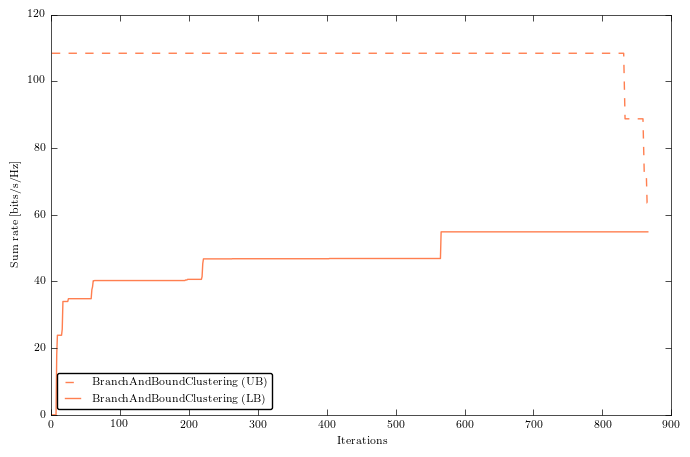

In [7]:
plot_params_bounds = Dict(
    "plot_name" => "bounds",

    "objective" => :none,

    "figure" => Dict(
        :figsize => (8,5),
        :dpi => 125,
    ),

    "axes" => Dict(
        :xlabel => "Iterations",
        :ylabel => "Sum rate [bits/s/Hz]",
    ),

    "legend" => Dict(
        :loc => "best",
    ),

    "methods" => Dict(
        "BranchAndBoundClustering" => [
            ("upper_bound_evolution", Dict(:color => "Coral", :linestyle => "--", :label => "BranchAndBoundClustering (UB)")),
            ("lower_bound_evolution", Dict(:color => "Coral", :linestyle => "-", :label => "BranchAndBoundClustering (LB)")),
        ],
    )
)
processed_results = postprocess_assignment_convergence(raw_results, simulation_params, plot_params_bounds)
plot_assignment_convergence(processed_results, simulation_params, plot_params_bounds, user_plots=false)